<span style='color:#0066cc'> <span style='font-family:serif'> <font size="6"> **Access MERRA-2 and OSCAR Data with OPeNDAP**<span style='color:#0066cc'>

Data sources:

- [MERRA-2](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/) (Modern-Era Retrospective analysis for Research and Applications, Version 2). Atmospheric (reanalysis) data. No ocean velocity data
- [OSCAR](https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_FINAL_V2.0) (Ocean Surface Current Analyses Real-time (OSCAR) Surface Currents - Final 0.25 Degree (Version 2.0)). 
- Iceberg Data (csv data from Kaggle)





In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydap.net import create_session
from pydap.client import get_cmr_urls, consolidate_metadata, open_url
import xarray as xr
import datetime as dt
import json
import numpy as np
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt

In [3]:
path = "./"
csv_files = sorted(glob.glob(os.path.join(path, "*.csv")))
dates = []
Coords = []
Times = []
DFs = []
for file in csv_files:
    df = pd.read_csv(file)
    df = df[~df['Remarks'].str.contains("grounded", na=False)]
    DFs.append(df)
    times = dt.datetime.strptime(("-").join(df["Last Update"].values[0].split("/")), "%m-%d-%Y").strftime("%Y-%m-%dT%H:%M:%SZ")
    dates.append(2*[times])
    Coords.append(df[["Longitude", "Latitude", "Last Update"]])

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Import Token Authorization and create Session**
 


<font size="3.5"> Here we use the Bearer Token to create an authenticated session. The Bearer token should be stored on a local json file, after completed the `GetStarted` Notebook.



In [4]:
# load token json data
with open('token.json', 'r') as fp:
    token = json.load(fp)

# pass Token Authorization to a new Session.
my_session = create_session(use_cache=True, session_kwargs=token)

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Query opendap urls using NASA's CMR API**

In [5]:
merra2_doi = "10.5067/VJAFPLI1CSIV" # available e.g. GES DISC MERRA-2 documentation 
                                    # https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=MERRA-2
oscar_ccid = "C2098858642-POCLOUD"

In [6]:
# my_session.cache.clear()

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Filter data via Temporal Searches**


In [7]:
%%time
atms_urls = [] # I will put the urls here
ocean_urls = []
missing_data = []
for n in range(len(csv_files)):
    time_range = dates[n]
    url = get_cmr_urls(ccid=oscar_ccid, time_range=time_range, session=my_session)
    if len(url)>0:
        # found ocean data
        ocean_urls += url
        atms_urls += get_cmr_urls(doi=merra2_doi,time_range=time_range, session=my_session)
    else:
        missing_data.append(n)
        print("did not find ocean velocity data for ", time_range[0]) # prints 1st element of 2-element list

did not find ocean velocity data for  2022-08-05T00:00:00Z
did not find ocean velocity data for  2022-08-12T00:00:00Z
CPU times: user 231 ms, sys: 12.6 ms, total: 244 ms
Wall time: 258 ms


## Drop files that have no overlapping data 

This refers to dates when only OSCAR or MERRA-2 have data, but not both. In this case, there are only two of them! Will discard them.

List to modify:

- dates
- csv_files
- Coords



In [8]:
## Drop the files in which there is no overlapping OSCAR/MERRA-2 data.
arr = np.array(csv_files)
mask = np.ones(len(arr), dtype=bool)
mask[missing_data] = False
csv_files = arr[mask].tolist()

## Discard date data first
arr = np.array(dates)
mask = np.ones(len(arr), dtype=bool)
mask[missing_data] = False
dates = arr[mask].tolist()

## Lastly, discard Coord data
drop_set = set(missing_data)

# Keep only elements not at those indices
Coords = [val for i, val in enumerate(Coords) if i not in drop_set]


In [9]:
len(dates), len(csv_files), len(Coords)

(108, 108, 108)

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Server-side Metadata reduction**

<font size="3.5"> Many of NASA's files contain too many variables, beyond those of interest, and processing their metadata can add unnecessary time to data analysis workflows. Below, we use pydap directly to add query parameters (Constraint Expressions) that instruct the remote NASA OPeNDAP server which variables of interest we need.


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **MERRA-2 Data**

<font size="3.5"> We are only interested in Temperature, U and V velocitiies at 2 Meters (T2M, U2M, and V2M respectively)

In [10]:
# Turn urls into DAP4 urls
new_urls = [url.replace("https", "dap4") for url in atms_urls] # 

# Now, access a single remote dataset and identify the query parameters to only requests relevant variables
pyds = open_url(new_urls[0], session=my_session)

Keep_vars = ["/T2M", "/U2M", "/V2M"] # this are the variables we want
dims = list(set([dim for var in Keep_vars for dim in pyds[var].dims]))  # retain their dimensions
Keep_vars += dims
CE="?dap4.ce=" + (';').join(Keep_vars) # need to add this to each url

opendap_MERRA_urls = [url + CE for url in new_urls]
opendap_MERRA_urls[:2]

['dap4://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20190816.nc4?dap4.ce=/T2M;/U2M;/V2M;/time;/lat;/lon',
 'dap4://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20190823.nc4?dap4.ce=/T2M;/U2M;/V2M;/time;/lat;/lon']

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **OSCAR data**

<font size="3.5"> We are only interested in U and V geostrophic velocities (ug, vg, respectively), in addition to the coordinate values

In [11]:
# Turn urls into DAP4 urls
opendap_OSCAR_urls = [url.replace("https", "dap4") for url in ocean_urls] # 
opendap_OSCAR_urls[:2]

['dap4://opendap.earthdata.nasa.gov/collections/C2098858642-POCLOUD/granules/oscar_currents_final_20190816',
 'dap4://opendap.earthdata.nasa.gov/collections/C2098858642-POCLOUD/granules/oscar_currents_final_20190823']

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Consolidate metadata**

<font size="3.5"> All URLs belonging to the same Collection share many identical variables and metadata. The following function
reduces redundant metadata


In [12]:
my_session.cache.clear()

In [13]:
%%time
consolidate_metadata(opendap_MERRA_urls, concat_dim='time', session=my_session)

datacube has dimensions {'lon[0:1:575]', 'time[0:1:23]', 'lat[0:1:360]'} , and concat dim: `time`
CPU times: user 2.37 s, sys: 439 ms, total: 2.81 s
Wall time: 47.7 s


In [14]:
%%time
consolidate_metadata(opendap_OSCAR_urls, concat_dim='time', safe_mode=False, set_maps=True, session=my_session)

datacube has dimensions {'latitude[0:1:718]', 'longitude[0:1:1439]'} , and concat dim: `time`
CPU times: user 956 ms, sys: 368 ms, total: 1.32 s
Wall time: 51.9 s


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Create Virtually Aggregated Dataset with Xarray**

<font size="3.5"> Now, you can create a virtually aggregated view of the dataset that is ready to analyze with Xarray and Pydap as an engine.



<font size="3.5"> Will generate two distinct dataset:

1. `ds_merra` will contain all relevant atmospheric data, and
2. `ds_oscar` will contain all relevant ocean data.


In [15]:
%%time
ds_merra = xr.open_mfdataset(opendap_MERRA_urls, engine='pydap', session=my_session, combine='nested', concat_dim="time", chunks={"time":1})
ds_merra

CPU times: user 1.21 s, sys: 110 ms, total: 1.32 s
Wall time: 1.45 s


<xarray.Dataset> Size: 13GB
Dimensions:  (time: 2592, lat: 361, lon: 576)
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 21kB 2019-08-16T00:30:00 ... 2022-07-29T23...
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Data variables:
    T2M      (time, lat, lon) float64 4GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    U2M      (time, lat, lon) float64 4GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    V2M      (time, lat, lon) float64 4GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Wed Aug 28 05...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20190816.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2019-08-16
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2019-08-16
    RangeEndingTime:                   23:59:59.000000
    created:                           2025-01-07T19:38:40Z

In [16]:
%%time
ds_oscar = xr.open_mfdataset(opendap_OSCAR_urls, engine='pydap', session=my_session, combine='nested', concat_dim="time")
ds_oscar

CPU times: user 1.5 s, sys: 83.1 ms, total: 1.59 s
Wall time: 1.63 s


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 108, longitude: 1440, latitude: 719)
Coordinates:
    lon      (longitude) float64 12kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) object 864B 2019-08-16 00:00:00 ... 2022-07-29 00:00:00
    lat      (latitude) float64 6kB dask.array<chunksize=(719,), meta=np.ndarray>
Dimensions without coordinates: longitude, latitude
Data variables:
    u        (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    v        (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2019-08-16T00:00:00
    time_coverage_end:          2019-08-16T23:59:59
    date_created:               2022-01-14

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Sample by coordinates**

<font size="3.5"> The dimensions `latitude`, `longitude` do not match the name of the coordinates, despite both being 1D arrays. However, to use these we can load the coordinates `lat` and `lonat  into memory and query the indexes longitude and latitude that match our coordinates of interest.

<font size="3.5"> We will need:
- <font size="3.5"> Load `lat`, `lon` into memory, using the xarray `.load()` method
- <font size="3.5"> Check the valid range for each `lat` and `lon` coordinate. In the case of OSCAR data, `lon>=0`. If our in situ data has negative values, we will need to transform lon values to match the OSCAR value ranges.
- <font size="3.5"> Identify the indexes of `longitude` and `longitude` that match our coordinate values
- <font size="3.5"> Sample the data using these indexes.

In [17]:
ds_oscar['lon'], ds_oscar['lat'] = ds_oscar['lon'].load()-180, ds_oscar['lat'].load()

In [18]:
ds_oscar

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 108, longitude: 1440, latitude: 719)
Coordinates:
    lon      (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time     (time) object 864B 2019-08-16 00:00:00 ... 2022-07-29 00:00:00
    lat      (latitude) float64 6kB -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
Dimensions without coordinates: longitude, latitude
Data variables:
    u        (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    v        (time, longitude, latitude) float64 895MB dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2019-08-16T00:00:00
    time_coverage_end:          2019-08-16T23:59:59
    date_created:               2022-01-14

In [19]:
def find_closest_indices(array, target_values):
    """
    Finds the indices of the closest matching values in a NumPy array for multiple target values.

    Args:
        array (np.ndarray): The NumPy array to search in.
        target_values (list or np.ndarray): A list or array of target values.

    Returns:
        np.ndarray: A NumPy array containing the indices of the closest matching values.
    """
    indices = []
    for target_value in target_values:
        abs_diff = np.abs(array - target_value)
        closest_index = np.argmin(abs_diff)
        indices.append(closest_index)
    return np.array(indices)

In [20]:
lon, lat = ds_oscar['lon'], ds_oscar['lat']


### Will use the data from csv files

The `Coords` list created at the beginning, contains all the coordinates. The length and ordering of `Coords` corresponds to the length and ordering
of the dates of data.

In [23]:
sum([len(Coords[i]) for i in range(len(Coords))])

3178

In [24]:
len(dates)

108

In [25]:
iLons = [] # need to append list 
iLats = []
iTimes = [] # 0, 1, 2, ...
for i in range(len(dates)):
# for i in range(4, 5):
    indexes = find_closest_indices(lon.values, Coords[i]['Longitude'].values)
    # print(len(indexes)== len(Coords[i]))
    iLons += list(indexes)
    indexes = find_closest_indices(lat.values, Coords[i]['Latitude'].values)
    iLats += list(indexes)
    iTimes += len(list(indexes))*[i] # list of identical i-elements, of size that matches the size of indexes

### Create an indexer

xarray support indexing along n-pairs of points. We exploit that and xarray's lazy evaluation below


In [26]:
indexer = {
    "time": xr.DataArray(iTimes, dims="location"),
    "latitude": xr.DataArray(iLats, dims="location"),
    "longitude": xr.DataArray(iLons, dims="location"),
}

In [27]:
indexer

{'time': <xarray.DataArray (location: 3178)> Size: 25kB
 array([  0,   0,   0, ..., 107, 107, 107], shape=(3178,))
 Dimensions without coordinates: location,
 'latitude': <xarray.DataArray (location: 3178)> Size: 25kB
 array([ 98, 100,  94, ...,  68,  67,  64], shape=(3178,))
 Dimensions without coordinates: location,
 'longitude': <xarray.DataArray (location: 3178)> Size: 25kB
 array([ 488,  485, 1293, ...,  534,  545,  571], shape=(3178,))
 Dimensions without coordinates: location}

In [28]:
%%time
u_samples = ds_oscar["u"].isel(**indexer)
v_samples = ds_oscar["v"].isel(**indexer)


CPU times: user 3.79 ms, sys: 899 μs, total: 4.68 ms
Wall time: 4.08 ms


In [29]:
%%time
u_samples.load(), v_samples.load()

CPU times: user 13.6 s, sys: 7.85 s, total: 21.4 s
Wall time: 2min 51s


(<xarray.DataArray 'u' (location: 3178)> Size: 25kB
 array([-0.0429632 , -0.25641577,         nan, ...,         nan,
                nan,         nan], shape=(3178,))
 Coordinates:
     lon      (location) float64 25kB -58.0 -58.75 143.2 ... -46.5 -43.75 -37.25
     time     (location) object 25kB 2019-08-16 00:00:00 ... 2022-07-29 00:00:00
     lat      (location) float64 25kB -65.25 -64.75 -66.25 ... -73.0 -73.75
 Dimensions without coordinates: location
 Attributes:
     long_name:              zonal total surface current
     standard_name:          eastward_sea_water_velocity
     units:                  m s-1
     coverage_content_type:  modelResult
     valid_min:              -3.0
     valid_max:              3.0
     depth:                  15m
     comment:                Velocities are an average over the top 30m of the...
     source:                 SSH source: CMEMS SSALTO/DUACS SEALEVEL_GLO_PHY_L...
     Maps:                   ('/lon', '/lat', '/time'),
 <xarray.DataArr

## Split into different data files, and append them as columns to respective csv files



In [30]:
# Following snippet creates an indexer to split into N-csv related files using time indexes as a splitter

lengths_csv = [len(Coords[n]) for n in range(len(Coords))]
csv_splitter = []
csv_splitter.append([0,lengths_csv[0]])
for i in range(2, len(lengths_csv)+1):
    csv_splitter.append([sum(lengths_csv[:i-1]), sum(lengths_csv[:i])])

## Concatenate all NASA velocity data into a single dataframe with Iceberg data

In [31]:
# create a dataframe from velocity data

final_DFs = []

ii=107
for i in range(len(csv_splitter)):

    indexes = csv_splitter[ii]

    _df = pd.DataFrame({'u_lat': u_samples.lat[indexes[0]:indexes[1]].to_pandas(), 
                        'u_lon': u_samples.lon[indexes[0]:indexes[1]].to_pandas(), 
                        'u_times': u_samples.time[indexes[0]:indexes[1]].to_pandas(), 
                        'u': u_samples[indexes[0]:indexes[1]].to_pandas(), 
                         'v': v_samples[indexes[0]:indexes[1]].to_pandas()}).reset_index().drop(columns='location')


    # read original file to clean up and concatenate with new data
    df = pd.read_csv(csv_files[ii])
    df = df[~df['Remarks'].str.contains("grounded", na=False)].drop(columns='Remarks')

    # Re set to match all indexes

    _df = _df.set_index(df.index)
    final_df = pd.concat([df, _df], axis=1)
    final_DFs.append(final_df)
    # final_df


In [32]:
u_samples

<xarray.DataArray 'u' (location: 3178)> Size: 25kB
array([-0.0429632 , -0.25641577,         nan, ...,         nan,
               nan,         nan], shape=(3178,))
Coordinates:
    lon      (location) float64 25kB -58.0 -58.75 143.2 ... -46.5 -43.75 -37.25
    time     (location) object 25kB 2019-08-16 00:00:00 ... 2022-07-29 00:00:00
    lat      (location) float64 25kB -65.25 -64.75 -66.25 ... -73.0 -73.75
Dimensions without coordinates: location
Attributes:
    long_name:              zonal total surface current
    standard_name:          eastward_sea_water_velocity
    units:                  m s-1
    coverage_content_type:  modelResult
    valid_min:              -3.0
    valid_max:              3.0
    depth:                  15m
    comment:                Velocities are an average over the top 30m of the...
    source:                 SSH source: CMEMS SSALTO/DUACS SEALEVEL_GLO_PHY_L...
    Maps:                   ('/lon', '/lat', '/time')

## Include a visualization of where there is data

In [33]:
Lats, Lons = np.meshgrid(lat.values, lon.values)

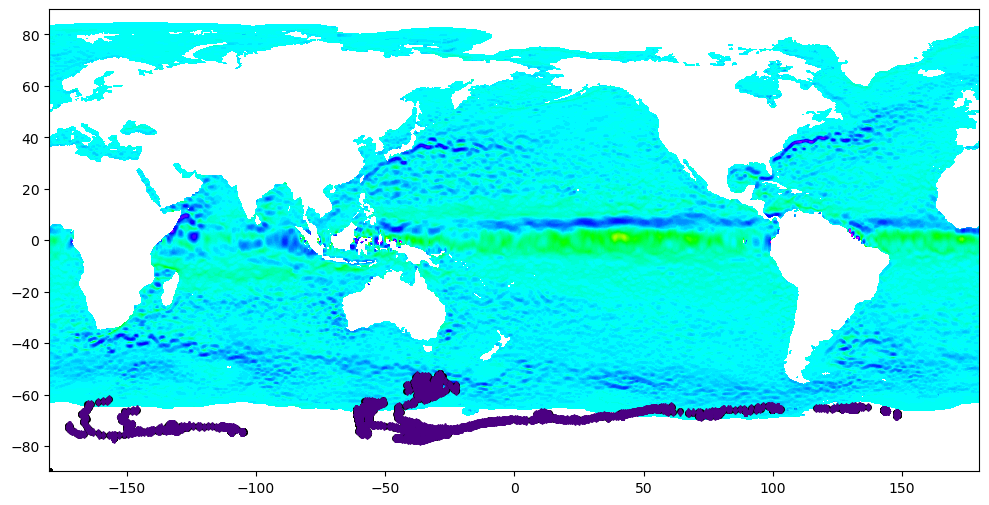

In [34]:
_ = plt.subplots(figsize=(12, 6))
plt.contourf(Lons, Lats, ds_oscar['u'].isel(time=-1), cmap='hsv', levels=np.linspace(-3, 3, 100))
plt.plot(lon.values[indexer['longitude']], lat.values[indexer['latitude']],ls='', marker='o',markersize=4, color='k')
for i in range(len(Coords)):
    plt.plot(Coords[i].Longitude.values, Coords[i].Latitude.values, ls='', marker='d', markersize=4, color='indigo')
plt.show()

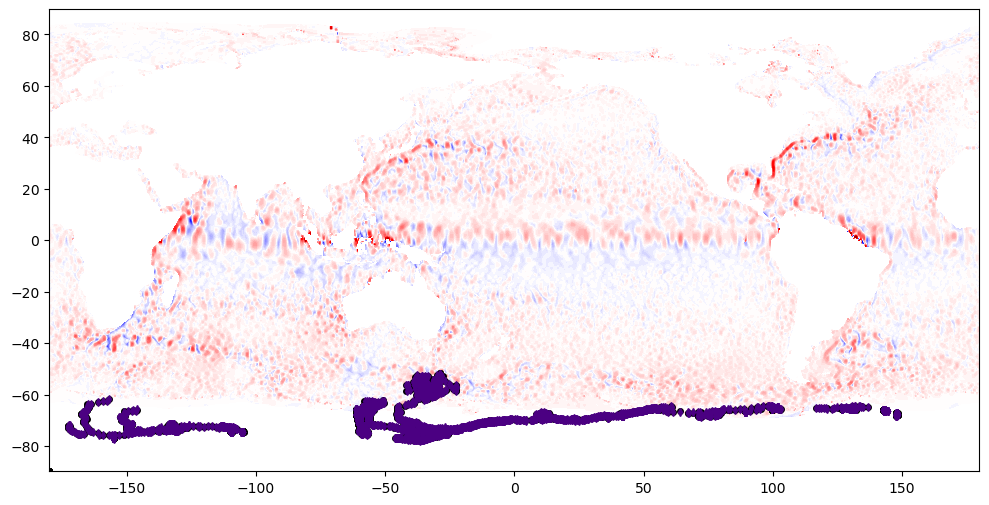

In [35]:
_ = plt.subplots(figsize=(12, 6))
plt.contourf(Lons, Lats, ds_oscar['v'].isel(time=-1), cmap='seismic', levels=np.linspace(-3, 3, 100))
plt.plot(lon.values[indexer['longitude']], lat.values[indexer['latitude']],ls='', marker='o',markersize=4, color='k')
for i in range(len(Coords)):
    plt.plot(Coords[i].Longitude.values, Coords[i].Latitude.values, ls='', marker='d', markersize=4, color='indigo')
plt.show()